<a href="https://colab.research.google.com/github/gthom73/MLIntegration_project4_group2/blob/main/machineLearningGroup2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np # linear algebra
import warnings # quiet python warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv("/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv") # read in csv data from kaggle 

/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv


In [47]:
!conda install -c pyviz hvplot -y

Channels:
 - pyviz
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - hvplot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.11            |       hd590300_1         542 KB  conda-forge
    attr-2.5.1                 |       h166bdaf_1          69 KB  conda-forge
    bokeh-3.4.1                |     pyhd8ed1ab_0         4.5 MB  conda-forge
    colorcet-3.1.0             |             py_0         445 KB  pyviz
    dbus-1.13.6                |       h5008d03_3         604 KB  conda-forge
    gettext-0.22.5             |       h59595ed_2         464 KB  conda-

In [73]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import hvplot.pandas
import tensorflow as tf
#from google.colab import files
#import os

# # Upload and configure the Kaggle API key
# uploaded = files.upload()  # Prompt to upload the kaggle.json file
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Install Kaggle API and download the dataset
# !pip install kaggle
# !kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

# Unzip the dataset with overwrite all option
#!unzip -o usa-real-estate-dataset.zip

# If needed, rename the file automatically
# correct_file_name = 'realtor-data.csv'
# extracted_file_name = 'realtor-data.zip.csv'

# Check if the extracted file is in the directory with a different name
# if extracted_file_name in os.listdir('.'):
#     os.rename(extracted_file_name, correct_file_name)

# Load the dataset and print the first 5 rows
# if correct_file_name in os.listdir('.'):
#     df = pd.read_csv(correct_file_name)
#     print(df.head(5))  # Print the first 5 rows of the dataframe
# else:
#     print(f"File {correct_file_name} not found in the directory.")

In [50]:
# List of cities to filter by
cities = ['Kansas City', 'Topeka', 'Denver', 'Dallas']

# Dictionary to map cities to their respective states (Kansas City can be in Missouri or Kansas)
city_states = {
    'Kansas City': ['Missouri', 'Kansas'],  # Kansas City can be in Missouri or Kansas
    'Topeka': ['Kansas'],
    'Denver': ['Colorado'],
    'Dallas': ['Texas']
}

# Loop through each city and display the first 5 rows for that city in the correct state(s)
for city, states in city_states.items():
    # Filter the DataFrame for the city and check if it's in one of the correct states
    filtered_df = df[(df['city'] == city) & (df['state'].isin(states))]

    # Check if the filtered dataframe is empty
    if not filtered_df.empty:
        print(f"First 5 rows for {city}, States: {', '.join(states)}:")
        print(filtered_df.head(5))
    else:
        print(f"No data available for {city} in {', '.join(states)}")

First 5 rows for Kansas City, States: Missouri, Kansas:
        brokered_by    status     price  bed  bath  acre_lot     street  \
914988        322.0  for_sale  372000.0  4.0   3.0      0.19  1614471.0   
914989      58270.0  for_sale   25000.0  3.0   2.0      0.35   144563.0   
914990      84610.0  for_sale   69950.0  2.0   1.0      0.19  1648065.0   
914994      33478.0  for_sale  109000.0  2.0   3.0      0.07  1747899.0   
915001      20177.0  for_sale  137500.0  4.0   1.0      0.23  1740406.0   

               city     state  zip_code  house_size prev_sold_date  
914988  Kansas City  Missouri   64158.0      2300.0     2016-09-09  
914989  Kansas City  Missouri   64133.0      1884.0     2004-03-22  
914990  Kansas City  Missouri   64129.0      1134.0            NaN  
914994  Kansas City  Missouri   64134.0      2062.0     2005-01-13  
915001  Kansas City  Missouri   64134.0       912.0     2008-02-06  
First 5 rows for Topeka, States: Kansas:
        brokered_by    status     pric

In [51]:
# List of cities to analyze
cities = ['Kansas City', 'Topeka', 'Denver', 'Dallas']

# Filter the DataFrame for these cities
filtered_df = df[df['city'].isin(cities)]

# Group by city and number of bedrooms, then calculate count and mean price
result = filtered_df.groupby(['city', 'bed']).agg(
    Houses_Available=('price', 'count'),
    Average_Price=('price', 'mean')
).reset_index()

# Format the Average Price to be more readable
result['Average_Price'] = result['Average_Price'].round(2)

print(result)

           city    bed  Houses_Available  Average_Price
0        Dallas    1.0               413      228606.82
1        Dallas    2.0              1588      399111.65
2        Dallas    3.0              3399      474756.44
3        Dallas    4.0              1938      698018.75
4        Dallas    5.0               483     1382225.59
5        Dallas    6.0                86     2103946.91
6        Dallas    7.0                10     5322690.00
7        Dallas    8.0                16     2841325.00
8        Dallas    9.0                 2     8525000.00
9        Dallas   10.0                 1     1597500.00
10       Dallas   14.0                 2     1029500.00
11       Dallas   23.0                 1      680000.00
12       Dallas   28.0                 1     3975000.00
13       Dallas   62.0                 1     6500000.00
14       Dallas  222.0                 1      699000.00
15       Denver    1.0               277      442537.16
16       Denver    2.0               717      56

In [52]:
# List of cities to analyze and their acceptable states
city_states = {
    'Kansas City': ['Missouri', 'Kansas'],  # Kansas City can be in Missouri or Kansas
    'Topeka': ['Kansas'],
    'Denver': ['Colorado'],
    'Dallas': ['Texas']
}

# Convert city_states dictionary to a DataFrame for easier filtering
cities_df = pd.DataFrame([(city, state) for city, states in city_states.items() for state in states], columns=['city', 'state'])

# Merge the cities DataFrame with the main DataFrame to filter correctly by city and state
filtered_df = pd.merge(df, cities_df, on=['city', 'state'])

# Further filter the DataFrame to ensure the number of bedrooms is 5 or less
filtered_df = filtered_df[filtered_df['bed'] <= 5]

# Group by city, state, and number of bedrooms ('bed'), then calculate count and mean price
result = filtered_df.groupby(['city', 'state', 'bed']).agg(
    Houses_Available=('price', 'count'),
    Average_Price=('price', 'mean')
).reset_index()

# Format the Average Price to be more readable
# result['Average_Price'] = result['Average_Price'].round(2)

# Display the results
print(result)

           city     state  bed  Houses_Available  Average_Price
0        Dallas     Texas  1.0               411   2.292110e+05
1        Dallas     Texas  2.0              1518   4.041147e+05
2        Dallas     Texas  3.0              2964   4.906751e+05
3        Dallas     Texas  4.0              1625   7.563900e+05
4        Dallas     Texas  5.0               368   1.664240e+06
5        Denver  Colorado  1.0               276   4.415018e+05
6        Denver  Colorado  2.0               675   5.739799e+05
7        Denver  Colorado  3.0               663   7.055124e+05
8        Denver  Colorado  4.0               454   9.796274e+05
9        Denver  Colorado  5.0               172   1.611205e+06
10  Kansas City    Kansas  1.0                 2   1.525000e+05
11  Kansas City    Kansas  2.0                79   1.719589e+05
12  Kansas City    Kansas  3.0               149   2.115802e+05
13  Kansas City    Kansas  4.0                66   4.782514e+05
14  Kansas City    Kansas  5.0          

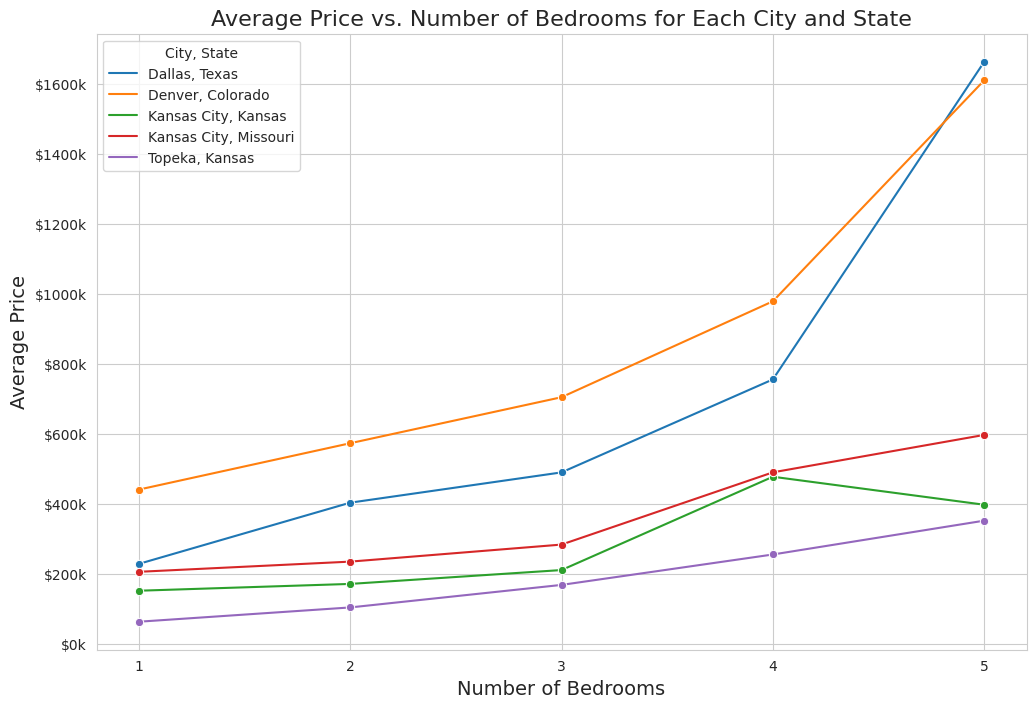

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a new column 'City_State' combining city and state for clearer labeling in the graph
result['City_State'] = result['city'] + ', ' + result['state']

# Create a line plot
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=result, x='bed', y='Average_Price', hue='City_State', marker='o')

# Adding titles and labels
plt.title('Average Price vs. Number of Bedrooms for Each City and State', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(result['bed'].unique())  # Ensure all bedroom categories are shown

# Format the y-axis to show dollar sign and the value
lineplot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x/1000)}k'))

# Enhance the legend for better clarity
plt.legend(title='City, State')
plt.show()

In [54]:
result.head()

,city,state,bed,Houses_Available,Average_Price,City_State
0,Dallas,Texas,1.0,411,2.292110e+05,"Dallas, Texas"
1,Dallas,Texas,2.0,1518,4.041147e+05,"Dallas, Texas"
2,Dallas,Texas,3.0,2964,4.906751e+05,"Dallas, Texas"
3,Dallas,Texas,4.0,1625,7.563900e+05,"Dallas, Texas"
4,Dallas,Texas,5.0,368,1.664240e+06,"Dallas, Texas"


In [61]:
# split target column from dataset
y = result['Average_Price']
X = result.drop(columns=['city', 'state','Average_Price'])

In [62]:
# Preview the data
X[:5]

,bed,Houses_Available,City_State
0,1.0,411,"Dallas, Texas"
1,2.0,1518,"Dallas, Texas"
2,3.0,2964,"Dallas, Texas"
3,4.0,1625,"Dallas, Texas"
4,5.0,368,"Dallas, Texas"


In [63]:
# Encode the categorical variables using get_dummies(X)
X = pd.get_dummies(X)

In [64]:
# Preview the data
X.head()

,bed,Houses_Available,"City_State_Dallas, Texas","City_State_Denver, Colorado","City_State_Kansas City, Kansas","City_State_Kansas City, Missouri","City_State_Topeka, Kansas"
0,1.0,411,True,False,False,False,False
1,2.0,1518,True,False,False,False,False
2,3.0,2964,True,False,False,False,False
3,4.0,1625,True,False,False,False,False
4,5.0,368,True,False,False,False,False


In [65]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [70]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [74]:
model = KNeighborsClassifier(n_neighbors=3)